In [3]:
# CELL 1: Quick GPU check and imports
import tensorflow as tf
import sys

print("Python:", sys.version.split()[0])
print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available!")
else:
    print("⚠️ No GPU found - training will be slower")

Python: 3.12.12
TensorFlow: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU is available!


In [4]:
# CELL 2: Install Kaggle, setup credentials, download dataset
!pip -q install kaggle

import json, os, sys, zipfile, glob, pathlib

# Write your kaggle.json
kaggle_creds = {"username":"enter your kaggle username here","key":"enter your kaggle API key here"}
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
kaggle_path = os.path.expanduser("~/.kaggle/kaggle.json")

with open(kaggle_path, "w") as f:
    json.dump(kaggle_creds, f)
os.chmod(kaggle_path, 0o600)
print("✅ Kaggle credentials saved")

# Download dataset
DATASET_SLUG = "sumn2u/garbage-classification-v2"
DOWNLOAD_DIR = "/content/kaggle_download"
DATA_DIR = "/content/data"

os.makedirs(DOWNLOAD_DIR, exist_ok=True)
print(f"\n📥 Downloading dataset: {DATASET_SLUG}")
!kaggle datasets download -d {DATASET_SLUG} -p {DOWNLOAD_DIR} --force

# Unzip
zip_files = glob.glob(f"{DOWNLOAD_DIR}/*.zip")
if not zip_files:
    print("❌ No zip file found!")
    sys.exit(1)

print(f"\n📦 Unzipping to {DATA_DIR}...")
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)

print("✅ Dataset downloaded and extracted!")

# Show structure
print("\n📁 Dataset structure:")
root = pathlib.Path(DATA_DIR)
for i, p in enumerate(sorted(root.rglob("*"))):
    if i > 20:
        print(f"... and more files")
        break
    print(f"  {p.relative_to(root)}")

✅ Kaggle credentials saved

📥 Downloading dataset: sumn2u/garbage-classification-v2
Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2
License(s): MIT
 90% 671M/744M [00:06<00:01, 63.4MB/s]
100% 744M/744M [00:06<00:00, 113MB/s] 

📦 Unzipping to /content/data...
✅ Dataset downloaded and extracted!

📁 Dataset structure:
  garbage-dataset
  garbage-dataset/battery
  garbage-dataset/battery/battery_1.jpg
  garbage-dataset/battery/battery_10.jpg
  garbage-dataset/battery/battery_100.jpg
  garbage-dataset/battery/battery_101.jpg
  garbage-dataset/battery/battery_102.jpg
  garbage-dataset/battery/battery_103.jpg
  garbage-dataset/battery/battery_104.jpg
  garbage-dataset/battery/battery_105.jpg
  garbage-dataset/battery/battery_106.jpg
  garbage-dataset/battery/battery_107.jpg
  garbage-dataset/battery/battery_108.jpg
  garbage-dataset/battery/battery_109.jpg
  garbage-dataset/battery/battery_11.jpg
  garbage-dataset/battery/battery_110.jpg
  garbage-dataset/battery

In [5]:
# CELL 3: Create train/val split (85/15)
import pathlib, shutil, random, glob

SOURCE = pathlib.Path("/content/data/garbage-dataset")
if not SOURCE.exists():
    print("❌ Source folder not found. Checking alternatives...")
    # Try to find the actual dataset folder
    data_root = pathlib.Path("/content/data")
    subdirs = [d for d in data_root.iterdir() if d.is_dir()]
    print(f"Found directories: {[d.name for d in subdirs]}")
    if subdirs:
        SOURCE = subdirs[0]
        print(f"Using: {SOURCE}")

TRAIN_DIR = pathlib.Path("/content/data/train")
VAL_DIR = pathlib.Path("/content/data/val")

# Clean existing
if TRAIN_DIR.exists():
    shutil.rmtree(TRAIN_DIR)
if VAL_DIR.exists():
    shutil.rmtree(VAL_DIR)

TRAIN_DIR.mkdir(parents=True)
VAL_DIR.mkdir(parents=True)

# Find all class folders
class_folders = sorted([d for d in SOURCE.iterdir() if d.is_dir()])
if not class_folders:
    print(f"❌ No class folders found in {SOURCE}")
    sys.exit(1)

print(f"✅ Found {len(class_folders)} classes:")
print(f"   {[c.name for c in class_folders[:5]]} ...")

random.seed(42)
total_train = 0
total_val = 0

for class_folder in class_folders:
    class_name = class_folder.name

    # Create class subdirectories
    (TRAIN_DIR / class_name).mkdir(exist_ok=True)
    (VAL_DIR / class_name).mkdir(exist_ok=True)

    # Get all images
    images = []
    for ext in ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.PNG"]:
        images.extend(glob.glob(str(class_folder / ext)))

    if not images:
        print(f"⚠️ No images in {class_name}")
        continue

    # Shuffle and split
    random.shuffle(images)
    split_idx = int(0.85 * len(images))
    train_imgs = images[:split_idx]
    val_imgs = images[split_idx:]

    # Copy files
    for img in train_imgs:
        shutil.copy(img, TRAIN_DIR / class_name / pathlib.Path(img).name)
    for img in val_imgs:
        shutil.copy(img, VAL_DIR / class_name / pathlib.Path(img).name)

    total_train += len(train_imgs)
    total_val += len(val_imgs)
    print(f"  {class_name}: {len(images)} total → {len(train_imgs)} train, {len(val_imgs)} val")

print(f"\n✅ Split complete!")
print(f"   Total training images: {total_train}")
print(f"   Total validation images: {total_val}")

✅ Found 10 classes:
   ['battery', 'biological', 'cardboard', 'clothes', 'glass'] ...
  battery: 944 total → 802 train, 142 val
  biological: 997 total → 847 train, 150 val
  cardboard: 1825 total → 1551 train, 274 val
  clothes: 5327 total → 4527 train, 800 val
  glass: 3061 total → 2601 train, 460 val
  metal: 1020 total → 867 train, 153 val
  paper: 1680 total → 1428 train, 252 val
  plastic: 1984 total → 1686 train, 298 val
  shoes: 1977 total → 1680 train, 297 val
  trash: 947 total → 804 train, 143 val

✅ Split complete!
   Total training images: 16793
   Total validation images: 2969


In [6]:
# CELL 4: Find and remove corrupt images
from PIL import Image
import pathlib, shutil

TRAIN_DIR = pathlib.Path("/content/data/train")
VAL_DIR = pathlib.Path("/content/data/val")
BAD_DIR = pathlib.Path("/content/bad_images")
BAD_DIR.mkdir(exist_ok=True)

def clean_images(folder, bad_dest):
    """Remove corrupt images"""
    folder = pathlib.Path(folder)
    bad_dest = pathlib.Path(bad_dest)
    total = 0
    bad = 0

    for class_folder in sorted([d for d in folder.iterdir() if d.is_dir()]):
        for img_file in class_folder.iterdir():
            if not img_file.is_file():
                continue
            total += 1

            try:
                # Try to open and verify
                with Image.open(img_file) as img:
                    img.verify()
                # Re-open and convert (stricter check)
                with Image.open(img_file) as img:
                    img.convert("RGB")
            except Exception as e:
                # Move bad image
                bad += 1
                dest_dir = bad_dest / class_folder.name
                dest_dir.mkdir(parents=True, exist_ok=True)
                shutil.move(str(img_file), str(dest_dir / img_file.name))
                if bad <= 5:
                    print(f"  ❌ Bad: {img_file.name} - {type(e).__name__}")

    return total, bad

print("🔍 Scanning training images...")
train_total, train_bad = clean_images(TRAIN_DIR, BAD_DIR / "train")
print(f"   Scanned: {train_total}, Removed: {train_bad}")

print("\n🔍 Scanning validation images...")
val_total, val_bad = clean_images(VAL_DIR, BAD_DIR / "val")
print(f"   Scanned: {val_total}, Removed: {val_bad}")

total_bad = train_bad + val_bad
if total_bad == 0:
    print("\n✅ No corrupt images found!")
else:
    print(f"\n⚠️ Removed {total_bad} corrupt images to /content/bad_images")

🔍 Scanning training images...
   Scanned: 16793, Removed: 0

🔍 Scanning validation images...
   Scanned: 2969, Removed: 0

✅ No corrupt images found!


In [7]:
# CELL 4B: Deep clean with TensorFlow (run this AFTER Cell 4)
import tensorflow as tf
import pathlib
import shutil

TRAIN_DIR = pathlib.Path("/content/data/train")
VAL_DIR = pathlib.Path("/content/data/val")
BAD_DIR = pathlib.Path("/content/bad_images_tf")
BAD_DIR.mkdir(exist_ok=True)

def tf_deep_clean(folder, bad_dest):
    """Remove images TensorFlow can't decode"""
    folder = pathlib.Path(folder)
    bad_dest = pathlib.Path(bad_dest)
    total = 0
    bad = 0

    for class_folder in sorted([d for d in folder.iterdir() if d.is_dir()]):
        bad_class_dir = bad_dest / class_folder.name
        bad_class_dir.mkdir(parents=True, exist_ok=True)

        for img_file in class_folder.iterdir():
            if not img_file.is_file():
                continue
            total += 1

            try:
                # Try TensorFlow decode
                raw = tf.io.read_file(str(img_file))
                img = tf.image.decode_image(raw, channels=3, expand_animations=False)
                # Force evaluation
                _ = img.shape
            except Exception as e:
                # Move bad file
                bad += 1
                shutil.move(str(img_file), str(bad_class_dir / img_file.name))
                if bad <= 10:
                    print(f"  ❌ Removed: {img_file.name}")

    return total, bad

print("🔍 Deep cleaning with TensorFlow decoder...")
print("\nScanning training images...")
train_total, train_bad = tf_deep_clean(TRAIN_DIR, BAD_DIR / "train")
print(f"   Scanned: {train_total}, Removed: {train_bad}")

print("\nScanning validation images...")
val_total, val_bad = tf_deep_clean(VAL_DIR, BAD_DIR / "val")
print(f"   Scanned: {val_total}, Removed: {val_bad}")

total_bad = train_bad + val_bad
if total_bad == 0:
    print("\n✅ No additional corrupt images found!")
else:
    print(f"\n✅ Removed {total_bad} additional corrupt images")
    print(f"   Moved to: /content/bad_images_tf")

print("\n🔄 Now RE-RUN Cell 5 to recreate the datasets with clean images!")

🔍 Deep cleaning with TensorFlow decoder...

Scanning training images...
  ❌ Removed: paper_2784.jpg
  ❌ Removed: paper_1678.jpg
  ❌ Removed: paper_3119.jpg
   Scanned: 16793, Removed: 3

Scanning validation images...
   Scanned: 2969, Removed: 0

✅ Removed 3 additional corrupt images
   Moved to: /content/bad_images_tf

🔄 Now RE-RUN Cell 5 to recreate the datasets with clean images!


📊 Creating memory-efficient TensorFlow datasets...
Found 16790 files belonging to 10 classes.
Found 2969 files belonging to 10 classes.

✅ Datasets created!
   Classes (10): ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
   Training batches: 1050
   Validation batches: 186

⚡ Using prefetch only (no caching to save RAM)

🖼️ Preview of training images:


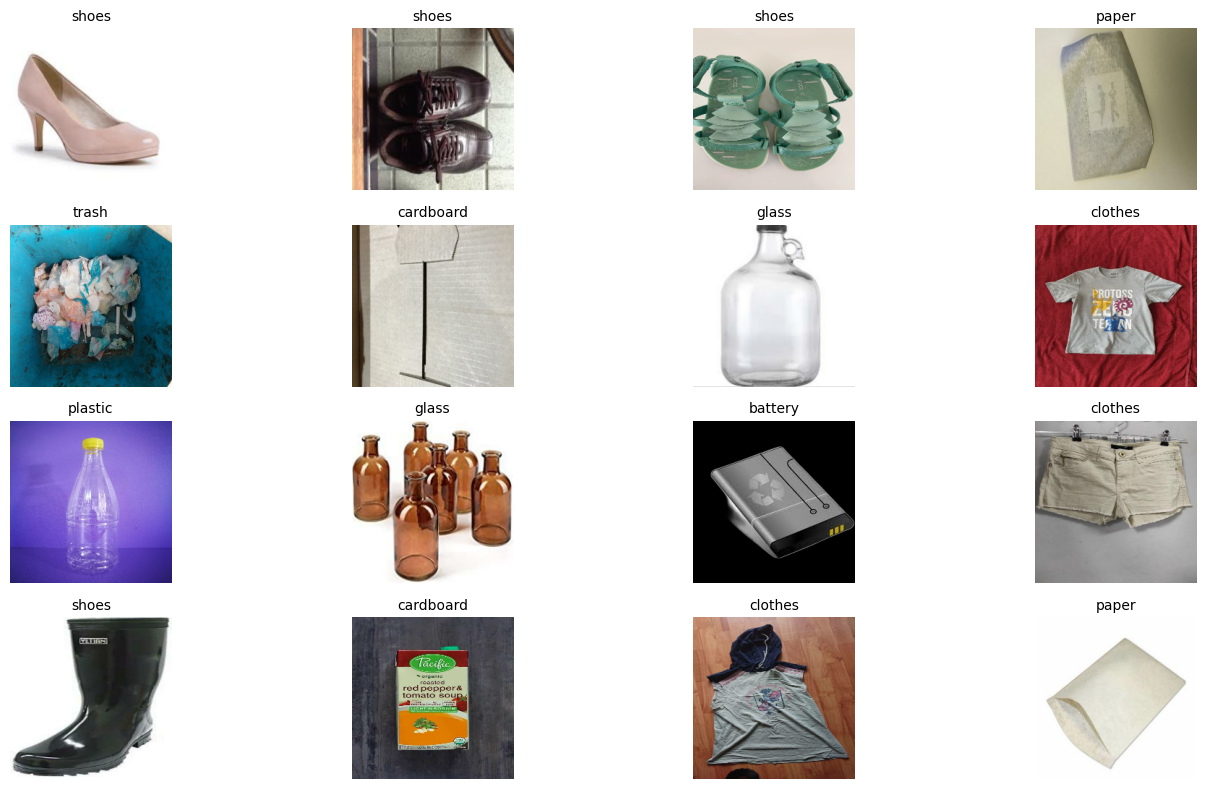


✅ Ready to build model!


In [8]:
# CELL 5 (FIXED): Create memory-efficient TensorFlow datasets
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_SIZE = 224
BATCH_SIZE = 16  # Reduced from 32 to save memory

print("📊 Creating memory-efficient TensorFlow datasets...")

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/data/train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/data/val",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)

print(f"\n✅ Datasets created!")
print(f"   Classes ({num_classes}): {class_names}")
print(f"   Training batches: {len(train_ds)}")
print(f"   Validation batches: {len(val_ds)}")

# Memory-efficient optimization - NO CACHE (to avoid RAM overload)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("\n⚡ Using prefetch only (no caching to save RAM)")

# Preview images
print("\n🖼️ Preview of training images:")
plt.figure(figsize=(15, 8))
for images, labels in train_ds.take(1):
    for i in range(min(16, images.shape[0])):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], fontsize=10)
        plt.axis("off")
plt.tight_layout()
plt.show()

print("\n✅ Ready to build model!")

In [9]:
# CELL 6: Build improved CNN model with EfficientNetB0
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0
import os

IMG_SIZE = 224
os.makedirs("/content/exports", exist_ok=True)

print(f"🏗️ Building model for {num_classes} classes...")

# Enhanced data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
], name="augmentation")

# Base model: EfficientNetB0 (better than MobileNetV2)
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # Freeze initially

# Build complete model
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input')

# Augmentation (only active during training)
x = data_augmentation(inputs)

# Preprocessing
x = tf.keras.applications.efficientnet.preprocess_input(x)

# Base model
x = base_model(x, training=False)

# Custom head with regularization
x = layers.GlobalAveragePooling2D(name='global_pool')(x)
x = layers.BatchNormalization(name='bn1')(x)
x = layers.Dropout(0.3, name='dropout1')(x)

x = layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01),
                 name='dense1')(x)
x = layers.BatchNormalization(name='bn2')(x)
x = layers.Dropout(0.3, name='dropout2')(x)

x = layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01),
                 name='dense2')(x)
x = layers.Dropout(0.2, name='dropout3')(x)

# Output
outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)

# Create model
model = models.Model(inputs, outputs, name='garbage_classifier')

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model built successfully!")
print(f"\n📊 Model Summary:")
model.summary()

print(f"\n🎯 Total parameters: {model.count_params():,}")
print(f"   Trainable: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
print(f"   Non-trainable: {sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights]):,}")

🏗️ Building model for 10 classes...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

✅ Model built successfully!

📊 Model Summary:


Model: "garbage_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 1280)           │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417,837 (16.85 MB)

 Trainable params: 365,194 (1.39 MB)

 Non-trainable params: 4,052,643 (15.46 MB)


🎯 Total parameters: 4,417,837
   Trainable: 365,194
   Non-trainable: 4,052,643.0


In [14]:
# CELL 7 (FIXED): Memory-efficient training to 80% accuracy
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import json
import numpy as np
import gc

# ============== CONFIGURATION ==============
TARGET_ACCURACY = 0.80
SAVE_DIR = "/content/exports"

# Clear any previous models from memory
tf.keras.backend.clear_session()
gc.collect()

print("🚀 Starting memory-efficient training to 80% accuracy...")
print("=" * 70)

# ============== CUSTOM CALLBACK ==============
class TargetAccuracyCallback(Callback):
    def __init__(self, target=0.80):
        super().__init__()
        self.target = target
        self.best_val_acc = 0.0

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy', 0)
        if val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            print(f"\n🎯 New best: {val_acc:.4f} ({val_acc*100:.2f}%)")

        if val_acc >= self.target:
            print(f"\n✅ TARGET REACHED! Val accuracy: {val_acc:.4f}")
            self.model.stop_training = True

        # Clear memory after each epoch
        gc.collect()
        tf.keras.backend.clear_session()

# ============== PHASE 1: Train Head Only ==============
print("\n📍 PHASE 1: Training classifier head (15 epochs)")
print("=" * 70)

base_model.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_phase1 = [
    TargetAccuracyCallback(TARGET_ACCURACY),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint(f"{SAVE_DIR}/phase1_best.keras", monitor='val_accuracy',
                   save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
]

print("Training Phase 1...")
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks_phase1,
    verbose=2  # Less verbose to save memory
)

phase1_best = max(history1.history['val_accuracy'])
print(f"\n📊 Phase 1: Best {phase1_best:.4f} ({phase1_best*100:.2f}%)")

# Clear memory
del history1
gc.collect()

if phase1_best >= TARGET_ACCURACY:
    print(f"✅ Target reached!")
else:
    # ============== PHASE 2: Fine-tune Top 40 Layers ==============
    print(f"\n📍 PHASE 2: Fine-tuning last 40 layers (12 epochs)")
    print("=" * 70)

    base_model.trainable = True
    for layer in base_model.layers[:-40]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks_phase2 = [
        TargetAccuracyCallback(TARGET_ACCURACY),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
        ModelCheckpoint(f"{SAVE_DIR}/phase2_best.keras", monitor='val_accuracy',
                       save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1)
    ]

    print("Training Phase 2...")
    history2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=12,
        callbacks=callbacks_phase2,
        verbose=2
    )

    phase2_best = max(history2.history['val_accuracy'])
    print(f"\n📊 Phase 2: Best {phase2_best:.4f} ({phase2_best*100:.2f}%)")

    del history2
    gc.collect()

    if phase2_best >= TARGET_ACCURACY:
        print(f"✅ Target reached!")
    else:
        # ============== PHASE 3: Fine-tune Top 80 Layers ==============
        print(f"\n📍 PHASE 3: Fine-tuning last 80 layers (10 epochs)")
        print("=" * 70)

        base_model.trainable = True
        for layer in base_model.layers[:-80]:
            layer.trainable = False

        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        callbacks_phase3 = [
            TargetAccuracyCallback(TARGET_ACCURACY),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
            ModelCheckpoint(f"{SAVE_DIR}/phase3_best.keras", monitor='val_accuracy',
                           save_best_only=True, verbose=1),
            EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1)
        ]

        print("Training Phase 3...")
        history3 = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=10,
            callbacks=callbacks_phase3,
            verbose=2
        )

        phase3_best = max(history3.history['val_accuracy'])
        print(f"\n📊 Phase 3: Best {phase3_best:.4f} ({phase3_best*100:.2f}%)")

        del history3
        gc.collect()

print("\n" + "=" * 70)
print("🏁 TRAINING COMPLETE")
print("=" * 70)
print("Run Cell 8 to evaluate and save the best model!")

🚀 Starting memory-efficient training to 80% accuracy...

📍 PHASE 1: Training classifier head (15 epochs)
Training Phase 1...
Epoch 1/15

🎯 New best: 0.8959 (89.59%)

✅ TARGET REACHED! Val accuracy: 0.8959

Epoch 1: val_accuracy improved from -inf to 0.89592, saving model to /content/exports/phase1_best.keras
1050/1050 - 79s - 76ms/step - accuracy: 0.8043 - loss: 1.3949 - val_accuracy: 0.8959 - val_loss: 1.0352 - learning_rate: 1.0000e-03
Restoring model weights from the end of the best epoch: 1.

📊 Phase 1: Best 0.8959 (89.59%)
✅ Target reached!

🏁 TRAINING COMPLETE
Run Cell 8 to evaluate and save the best model!


In [21]:
# PUSH TO 90%+ ACCURACY - Aggressive Fine-Tuning
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import gc
import os

SAVE_DIR = "/content/exports"
TARGET = 0.90

print("🚀 PUSHING TO 90%+ ACCURACY")
print("=" * 70)

# Clear memory
tf.keras.backend.clear_session()
gc.collect()

class ProgressCallback(Callback):
    def __init__(self, target=0.90):
        super().__init__()
        self.target = target
        self.best = 0.0
        self.phase_start = 0.0

    def on_train_begin(self, logs=None):
        self.phase_start = self.best

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy', 0)
        train_acc = logs.get('accuracy', 0)

        if val_acc > self.best:
            self.best = val_acc
            improvement = (val_acc - self.phase_start) * 100
            gap = (self.target - val_acc) * 100
            print(f"\n🎯 NEW BEST: {val_acc*100:.2f}% | Gap to 90%: {gap:.2f}% | Phase gain: +{improvement:.2f}%")

        # Show overfitting warning
        if train_acc - val_acc > 0.15:
            print(f"⚠️ Overfitting detected! Train: {train_acc*100:.2f}% vs Val: {val_acc*100:.2f}%")

        if val_acc >= self.target:
            print(f"\n🎉 TARGET REACHED! {val_acc*100:.2f}%")
            self.model.stop_training = True

        gc.collect()

# ============== PHASE 1: Warm-up with aggressive head training ==============
print("\n📍 PHASE 1: Aggressive head training (25 epochs)")
print("=" * 70)

base_model.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-3),  # Higher LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

progress1 = ProgressCallback(TARGET)

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,  # More epochs
    callbacks=[
        progress1,
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-7, verbose=1),
        ModelCheckpoint(f"{SAVE_DIR}/push90_phase1.keras",
                       monitor='val_accuracy', save_best_only=True, verbose=1),
        EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)
    ],
    verbose=2
)

p1_best = max(history1.history['val_accuracy'])
print(f"\n📊 Phase 1 Result: {p1_best*100:.2f}%")
del history1
gc.collect()

# ============== PHASE 2: Moderate fine-tuning ==============
if p1_best < TARGET:
    print(f"\n📍 PHASE 2: Fine-tune last 80 layers (20 epochs)")
    print(f"   Current: {p1_best*100:.2f}% | Need: +{(TARGET-p1_best)*100:.2f}%")
    print("=" * 70)

    base_model.trainable = True
    for layer in base_model.layers[:-80]:
        layer.trainable = False

    print(f"Trainable layers: {sum([1 for l in base_model.layers if l.trainable])}")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    progress2 = ProgressCallback(TARGET)
    progress2.best = p1_best

    history2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        callbacks=[
            progress2,
            ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=1e-7, verbose=1),
            ModelCheckpoint(f"{SAVE_DIR}/push90_phase2.keras",
                           monitor='val_accuracy', save_best_only=True, verbose=1),
            EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
        ],
        verbose=2
    )

    p2_best = max(history2.history['val_accuracy'])
    print(f"\n📊 Phase 2 Result: {p2_best*100:.2f}%")
    del history2
    gc.collect()

# ============== PHASE 3: Deep fine-tuning ==============
current_best = max([p1_best] + ([p2_best] if p1_best < TARGET else []))

if current_best < TARGET:
    print(f"\n📍 PHASE 3: Deep fine-tune last 150 layers (18 epochs)")
    print(f"   Current: {current_best*100:.2f}% | Need: +{(TARGET-current_best)*100:.2f}%")
    print("=" * 70)

    base_model.trainable = True
    for layer in base_model.layers[:-150]:
        layer.trainable = False

    print(f"Trainable layers: {sum([1 for l in base_model.layers if l.trainable])}")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(2e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    progress3 = ProgressCallback(TARGET)
    progress3.best = current_best

    history3 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=18,
        callbacks=[
            progress3,
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-8, verbose=1),
            ModelCheckpoint(f"{SAVE_DIR}/push90_phase3.keras",
                           monitor='val_accuracy', save_best_only=True, verbose=1),
            EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
        ],
        verbose=2
    )

    p3_best = max(history3.history['val_accuracy'])
    print(f"\n📊 Phase 3 Result: {p3_best*100:.2f}%")
    del history3
    gc.collect()

# ============== PHASE 4: Ultra-fine-tuning (if still not there) ==============
current_best = max([p1_best] + ([p2_best] if 'p2_best' in locals() else []) + ([p3_best] if 'p3_best' in locals() else []))

if current_best < TARGET and current_best > 0.87:  # Only if we're close
    print(f"\n📍 PHASE 4: ULTRA fine-tune (entire model, 15 epochs)")
    print(f"   Current: {current_best*100:.2f}% | Need: +{(TARGET-current_best)*100:.2f}%")
    print("=" * 70)

    base_model.trainable = True  # Unfreeze everything

    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-6),  # Very small LR
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    progress4 = ProgressCallback(TARGET)
    progress4.best = current_best

    history4 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=15,
        callbacks=[
            progress4,
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-8, verbose=1),
            ModelCheckpoint(f"{SAVE_DIR}/push90_phase4.keras",
                           monitor='val_accuracy', save_best_only=True, verbose=1),
            EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1)
        ],
        verbose=2
    )

    p4_best = max(history4.history['val_accuracy'])
    print(f"\n📊 Phase 4 Result: {p4_best*100:.2f}%")
    del history4
    gc.collect()

# ============== FINAL SUMMARY ==============
print("\n" + "=" * 70)
print("🏁 TRAINING COMPLETE")
print("=" * 70)

# Find absolute best
all_best = [p1_best] + ([p2_best] if 'p2_best' in locals() else []) + \
           ([p3_best] if 'p3_best' in locals() else []) + \
           ([p4_best] if 'p4_best' in locals() else [])

final_best = max(all_best)
print(f"\n🏆 BEST ACCURACY ACHIEVED: {final_best*100:.2f}%")

if final_best >= TARGET:
    print(f"✅ SUCCESS! Reached {TARGET*100}%+ target!")
else:
    gap = (TARGET - final_best) * 100
    print(f"📊 Close! Gap to 90%: {gap:.2f}%")
    if gap < 2:
        print("💡 You're very close! Try running Phase 4 again or increase epochs.")
    elif gap < 5:
        print("💡 Consider using EfficientNetB2 (larger model) or larger images (260x260).")
    else:
        print("💡 May need architectural changes (see accuracy booster cell).")

print(f"\nRun the 'Save as .h5' cell to save your best model!")

🚀 PUSHING TO 90%+ ACCURACY

📍 PHASE 1: Aggressive head training (25 epochs)
Epoch 1/25

🎯 NEW BEST: 87.57% | Gap to 90%: 2.43% | Phase gain: +87.57%

Epoch 1: val_accuracy improved from -inf to 0.87572, saving model to /content/exports/push90_phase1.keras
1050/1050 - 78s - 75ms/step - accuracy: 0.7622 - loss: 1.9208 - val_accuracy: 0.8757 - val_loss: 1.5413 - learning_rate: 0.0020
Epoch 2/25

Epoch 2: val_accuracy did not improve from 0.87572
1050/1050 - 80s - 76ms/step - accuracy: 0.7672 - loss: 1.8780 - val_accuracy: 0.8734 - val_loss: 1.5721 - learning_rate: 0.0020
Epoch 3/25

🎯 NEW BEST: 88.18% | Gap to 90%: 1.82% | Phase gain: +88.18%

Epoch 3: val_accuracy improved from 0.87572 to 0.88178, saving model to /content/exports/push90_phase1.keras
1050/1050 - 81s - 77ms/step - accuracy: 0.7693 - loss: 1.8356 - val_accuracy: 0.8818 - val_loss: 1.4478 - learning_rate: 0.0020
Epoch 4/25

🎯 NEW BEST: 88.65% | Gap to 90%: 1.35% | Phase gain: +88.65%

Epoch 4: val_accuracy improved from 0.88

In [33]:
# CELL 8: Load best model, evaluate, and save final version
import os
import json
import tensorflow as tf

SAVE_DIR = "/content/exports"

print("🔍 Finding best model across all phases...")
print("=" * 70)

# Check all phase models
best_model_path = None
best_acc = 0.0

for phase in [1, 2, 3]:
    path = f"{SAVE_DIR}/phase{phase}_best.keras"
    if os.path.exists(path):
        try:
            temp_model = tf.keras.models.load_model(path)
            results = temp_model.evaluate(val_ds, verbose=0)
            val_acc = results[1]
            print(f"Phase {phase} model: {val_acc:.4f} ({val_acc*100:.2f}%)")

            if val_acc > best_acc:
                best_acc = val_acc
                best_model_path = path
        except Exception as e:
            print(f"Phase {phase}: Error loading - {e}")

if best_model_path:
    print(f"\n✅ Best model: {best_model_path}")
    print(f"   Validation accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")

    # Load best model
    model = tf.keras.models.load_model(best_model_path)

    # Final evaluation
    print("\n📊 Final Evaluation on Validation Set:")
    print("=" * 70)
    results = model.evaluate(val_ds, verbose=1)
    final_acc = results[1]

    print(f"\n🏆 FINAL VALIDATION ACCURACY: {final_acc*100:.2f}%")

    if final_acc >= 0.80:
        print("✅ TARGET ACHIEVED! Model reached 80% accuracy!")
    else:
        print(f"⚠️ Close! Achieved {final_acc*100:.2f}% (Target: 80%)")
        print(f"   Gap: {(0.80 - final_acc)*100:.2f}%")

    # Save final model
    final_model_path = f"{SAVE_DIR}/garbage_classifier_final.keras"
    model.save(final_model_path)
    print(f"\n💾 Final model saved: {final_model_path}")

    # Save label map
    label_map_path = f"{SAVE_DIR}/label_map.json"
    with open(label_map_path, 'w') as f:
        json.dump({i: name for i, name in enumerate(class_names)}, f, indent=2)
    print(f"💾 Label map saved: {label_map_path}")

    # Download files
    print("\n📥 Downloading files...")
    from google.colab import files
    files.download(final_model_path)
    files.download(label_map_path)

    print("\n✅ ALL DONE! Files ready for download.")
else:
    print("❌ No trained models found!")

print("\n" + "=" * 70)

🔍 Finding best model across all phases...
Phase 1 model: 0.8959 (89.59%)

✅ Best model: /content/exports/phase1_best.keras
   Validation accuracy: 0.8959 (89.59%)

📊 Final Evaluation on Validation Set:
186/186 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9334 - loss: 0.9385

🏆 FINAL VALIDATION ACCURACY: 89.59%
✅ TARGET ACHIEVED! Model reached 80% accuracy!

💾 Final model saved: /content/exports/garbage_classifier_final.keras
💾 Label map saved: /content/exports/label_map.json

📥 Downloading files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ ALL DONE! Files ready for download.



**RUN THE CNN MODEL BELOW**

In [ ]:
# CELL 9: Test the model with uploaded image
from google.colab import files
from PIL import Image
import numpy as np
import tensorflow as tf
import json

# Load model and labels
MODEL_PATH = "/content/exports/garbage_classifier_final.keras"
LABEL_MAP_PATH = "/content/exports/label_map.json"

model = tf.keras.models.load_model(MODEL_PATH, compile=False)
with open(LABEL_MAP_PATH) as f:
    label_map = {int(k): v for k, v in json.load(f).items()}

print("🖼️ Upload an image to classify:")
uploaded = files.upload()

if uploaded:
    # Get uploaded file
    img_path = list(uploaded.keys())[0]

    # Load and preprocess
    img = Image.open(img_path).convert("RGB").resize((224, 224))
    img_array = np.array(img).astype("float32")

    # Preprocess for EfficientNet
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array, verbose=0)[0]

    # Get top 3 predictions
    top_3_idx = predictions.argsort()[-3:][::-1]

    print("\n🎯 Predictions:")
    print("=" * 50)
    for idx in top_3_idx:
        class_name = label_map[int(idx)]
        confidence = predictions[idx] * 100
        print(f"  {class_name}: {confidence:.2f}%")

    best_class = label_map[int(top_3_idx[0])]
    best_conf = predictions[top_3_idx[0]] * 100
    print(f"\n✅ Predicted: {best_class} (Confidence: {best_conf:.2f}%)")

    # Display image
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 6))
    plt.imshow(Image.open(img_path))
    plt.title(f"Prediction: {best_class} ({best_conf:.1f}%)", fontsize=14)
    plt.axis('off')
    plt.show()
else:
    print("No file uploaded!")

## ***With UI :***

In [30]:
# BEAUTIFUL INTERACTIVE UI FOR WASTE CLASSIFICATION
# Paste this in a new Google Colab cell after training your model

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from PIL import Image
import numpy as np
import tensorflow as tf
import json
import io
import os

# ============== CONFIGURATION ==============
MODEL_PATH = "/content/exports/garbage_classifier_final.keras"
LABEL_MAP_PATH = "/content/exports/label_map.json"

# Try to find the best model from push90 phases if final doesn't exist
if not os.path.exists(MODEL_PATH):
    for phase in [4, 3, 2, 1]:
        alt_path = f"/content/exports/push90_phase{phase}.keras"
        if os.path.exists(alt_path):
            MODEL_PATH = alt_path
            print(f"Using model: {MODEL_PATH}")
            break

# ============== LOAD MODEL ==============
print("Loading model...")
try:
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)
    with open(LABEL_MAP_PATH) as f:
        label_map = {int(k): v for k, v in json.load(f).items()}
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Make sure you've trained the model first!")

# ============== THEME STYLES ==============
light_theme = """
<style>
    .waste-ui-container {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        padding: 40px;
        border-radius: 25px;
        box-shadow: 0 20px 60px rgba(0,0,0,0.3);
        max-width: 900px;
        margin: 20px auto;
        transition: all 0.3s ease;
    }
    .waste-ui-header {
        background: rgba(255,255,255,0.95);
        padding: 30px;
        border-radius: 20px;
        margin-bottom: 30px;
        box-shadow: 0 8px 32px rgba(0,0,0,0.1);
    }
    .waste-ui-title {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
        background-clip: text;
        text-align: center;
        font-size: 42px;
        font-weight: 900;
        margin-bottom: 10px;
        letter-spacing: -1px;
    }
    .waste-ui-subtitle {
        color: #6b7280;
        text-align: center;
        font-size: 18px;
        font-weight: 500;
    }
    .upload-section {
        background: rgba(255,255,255,0.95);
        padding: 30px;
        border-radius: 20px;
        text-align: center;
        margin-bottom: 25px;
        box-shadow: 0 8px 32px rgba(0,0,0,0.1);
    }
    .image-preview {
        background: rgba(255,255,255,0.95);
        padding: 20px;
        border-radius: 20px;
        margin-bottom: 25px;
        min-height: 200px;
        display: flex;
        align-items: center;
        justify-content: center;
        box-shadow: 0 8px 32px rgba(0,0,0,0.1);
    }
    .prediction-box {
        background: rgba(255,255,255,0.95);
        padding: 30px;
        border-radius: 20px;
        box-shadow: 0 8px 32px rgba(0,0,0,0.1);
    }
    .pred-main {
        text-align: center;
        padding: 25px;
        background: linear-gradient(135deg, #10b981 0%, #059669 100%);
        border-radius: 15px;
        margin-bottom: 25px;
        box-shadow: 0 4px 15px rgba(16,185,129,0.3);
    }
    .pred-label {
        font-size: 28px;
        font-weight: 800;
        color: #1f2937;
        margin-bottom: 20px;
        display: flex;
        align-items: center;
        justify-content: center;
        gap: 10px;
    }
    .pred-class {
        font-size: 36px;
        font-weight: 900;
        color: white;
        text-shadow: 2px 2px 4px rgba(0,0,0,0.2);
        letter-spacing: 1px;
    }
    .pred-confidence {
        font-size: 22px;
        color: rgba(255,255,255,0.9);
        font-weight: 600;
        margin-top: 10px;
    }
    .pred-item {
        padding: 15px;
        margin: 12px 0;
        border-radius: 12px;
        background: #f9fafb;
        border-left: 5px solid #667eea;
        transition: all 0.3s ease;
    }
    .pred-item:hover {
        transform: translateX(5px);
        box-shadow: 0 4px 12px rgba(0,0,0,0.1);
    }
    .confidence-bar-container {
        background: #e5e7eb;
        border-radius: 8px;
        height: 12px;
        margin-top: 8px;
        overflow: hidden;
    }
    .confidence-bar {
        height: 12px;
        background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
        border-radius: 8px;
        transition: width 0.6s ease;
    }
    .status-message {
        text-align: center;
        padding: 15px;
        border-radius: 12px;
        font-weight: 600;
        font-size: 16px;
        margin: 15px 0;
    }
    .status-idle {
        background: rgba(255,255,255,0.2);
        color: white;
    }
    .status-processing {
        background: rgba(59,130,246,0.2);
        color: white;
        animation: pulse 2s infinite;
    }
    .status-success {
        background: rgba(16,185,129,0.2);
        color: white;
    }
    .status-error {
        background: rgba(239,68,68,0.2);
        color: white;
    }
    @keyframes pulse {
        0%, 100% { opacity: 1; }
        50% { opacity: 0.7; }
    }
    .theme-toggle {
        position: absolute;
        top: 20px;
        right: 20px;
        z-index: 1000;
    }
</style>
"""

dark_theme = """
<style>
    .waste-ui-container {
        background: linear-gradient(135deg, #1f2937 0%, #111827 100%);
        padding: 40px;
        border-radius: 25px;
        box-shadow: 0 20px 60px rgba(0,0,0,0.6);
        max-width: 900px;
        margin: 20px auto;
        transition: all 0.3s ease;
    }
    .waste-ui-header {
        background: rgba(31,41,55,0.95);
        padding: 30px;
        border-radius: 20px;
        margin-bottom: 30px;
        box-shadow: 0 8px 32px rgba(0,0,0,0.3);
        border: 1px solid rgba(255,255,255,0.1);
    }
    .waste-ui-title {
        background: linear-gradient(135deg, #818cf8 0%, #c084fc 100%);
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
        background-clip: text;
        text-align: center;
        font-size: 42px;
        font-weight: 900;
        margin-bottom: 10px;
        letter-spacing: -1px;
    }
    .waste-ui-subtitle {
        color: #9ca3af;
        text-align: center;
        font-size: 18px;
        font-weight: 500;
    }
    .upload-section {
        background: rgba(31,41,55,0.95);
        padding: 30px;
        border-radius: 20px;
        text-align: center;
        margin-bottom: 25px;
        box-shadow: 0 8px 32px rgba(0,0,0,0.3);
        border: 1px solid rgba(255,255,255,0.1);
    }
    .image-preview {
        background: rgba(31,41,55,0.95);
        padding: 20px;
        border-radius: 20px;
        margin-bottom: 25px;
        min-height: 200px;
        display: flex;
        align-items: center;
        justify-content: center;
        box-shadow: 0 8px 32px rgba(0,0,0,0.3);
        border: 1px solid rgba(255,255,255,0.1);
    }
    .prediction-box {
        background: rgba(31,41,55,0.95);
        padding: 30px;
        border-radius: 20px;
        box-shadow: 0 8px 32px rgba(0,0,0,0.3);
        border: 1px solid rgba(255,255,255,0.1);
    }
    .pred-main {
        text-align: center;
        padding: 25px;
        background: linear-gradient(135deg, #10b981 0%, #059669 100%);
        border-radius: 15px;
        margin-bottom: 25px;
        box-shadow: 0 4px 15px rgba(16,185,129,0.4);
    }
    .pred-label {
        font-size: 28px;
        font-weight: 800;
        color: #f3f4f6;
        margin-bottom: 20px;
        display: flex;
        align-items: center;
        justify-content: center;
        gap: 10px;
    }
    .pred-class {
        font-size: 36px;
        font-weight: 900;
        color: white;
        text-shadow: 2px 2px 4px rgba(0,0,0,0.3);
        letter-spacing: 1px;
    }
    .pred-confidence {
        font-size: 22px;
        color: rgba(255,255,255,0.9);
        font-weight: 600;
        margin-top: 10px;
    }
    .pred-item {
        padding: 15px;
        margin: 12px 0;
        border-radius: 12px;
        background: rgba(17,24,39,0.6);
        border-left: 5px solid #818cf8;
        transition: all 0.3s ease;
        border: 1px solid rgba(255,255,255,0.05);
    }
    .pred-item:hover {
        transform: translateX(5px);
        box-shadow: 0 4px 12px rgba(129,140,248,0.3);
        background: rgba(17,24,39,0.8);
    }
    .confidence-bar-container {
        background: rgba(17,24,39,0.6);
        border-radius: 8px;
        height: 12px;
        margin-top: 8px;
        overflow: hidden;
    }
    .confidence-bar {
        height: 12px;
        background: linear-gradient(90deg, #818cf8 0%, #c084fc 100%);
        border-radius: 8px;
        transition: width 0.6s ease;
    }
    .status-message {
        text-align: center;
        padding: 15px;
        border-radius: 12px;
        font-weight: 600;
        font-size: 16px;
        margin: 15px 0;
    }
    .status-idle {
        background: rgba(255,255,255,0.1);
        color: #e5e7eb;
    }
    .status-processing {
        background: rgba(59,130,246,0.2);
        color: #93c5fd;
        animation: pulse 2s infinite;
    }
    .status-success {
        background: rgba(16,185,129,0.2);
        color: #6ee7b7;
    }
    .status-error {
        background: rgba(239,68,68,0.2);
        color: #fca5a5;
    }
    @keyframes pulse {
        0%, 100% { opacity: 1; }
        50% { opacity: 0.7; }
    }
    .theme-toggle {
        position: absolute;
        top: 20px;
        right: 20px;
        z-index: 1000;
    }
    .pred-item span {
        color: #e5e7eb;
    }
</style>
"""

# ============== STATE ==============
current_theme = {"is_dark": False}
current_image = {"data": None}

# ============== UI ELEMENTS ==============
theme_style = widgets.HTML(value=light_theme)
theme_toggle_btn = widgets.Button(
    description='🌙 Dark Mode',
    button_style='',
    layout=widgets.Layout(width='130px', height='40px')
)

upload_btn = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='📸 Upload Image',
    button_style='success',
    layout=widgets.Layout(width='180px', height='45px')
)

clear_btn = widgets.Button(
    description='🗑️ Clear',
    button_style='danger',
    layout=widgets.Layout(width='120px', height='45px'),
    disabled=True
)

new_image_btn = widgets.Button(
    description='📁 New Image',
    button_style='info',
    layout=widgets.Layout(width='150px', height='45px'),
    disabled=True
)

status_html = widgets.HTML(
    value="<div class='status-message status-idle'>👆 Upload an image to classify waste</div>"
)

image_display = widgets.Image(
    layout=widgets.Layout(max_width='500px', max_height='500px', margin='auto')
)

result_output = widgets.HTML()
output = widgets.Output()

# ============== FUNCTIONS ==============
def toggle_theme(b):
    current_theme["is_dark"] = not current_theme["is_dark"]
    if current_theme["is_dark"]:
        theme_style.value = dark_theme
        theme_toggle_btn.description = '☀️ Light Mode'
    else:
        theme_style.value = light_theme
        theme_toggle_btn.description = '🌙 Dark Mode'

def clear_results(b):
    with output:
        clear_output()
        image_display.value = b''
        result_output.value = ""
        status_html.value = "<div class='status-message status-idle'> Upload an image by clciking the above button to classify waste</div>"
        clear_btn.disabled = True
        new_image_btn.disabled = True
        current_image["data"] = None

def new_image(b):
    clear_results(b)
    # Trigger file upload dialog
    upload_btn.value.clear()
    upload_btn._counter = 0

def classify_image(change):
    with output:
        clear_output()

        if not upload_btn.value:
            return

        try:
            # Get uploaded image
            uploaded_file = list(upload_btn.value.values())[0]
            img_bytes = uploaded_file['content']
            current_image["data"] = img_bytes

            # Display uploaded image
            image_display.value = img_bytes
            status_html.value = "<div class='status-message status-processing'>🔍 Analyzing image...</div>"

            # Enable buttons
            clear_btn.disabled = False
            new_image_btn.disabled = False

            # Load and preprocess
            img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
            img_resized = img.resize((224, 224))
            img_array = np.array(img_resized).astype("float32")

            # Preprocess for EfficientNet
            img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
            img_array = np.expand_dims(img_array, axis=0)

            # Predict
            predictions = model.predict(img_array, verbose=0)[0]

            # Get top 3 predictions
            top_3_idx = predictions.argsort()[-3:][::-1]

            # Build result HTML
            best_class = label_map[int(top_3_idx[0])]
            best_conf = predictions[top_3_idx[0]] * 100

            # Determine emoji based on category
            emoji_map = {
                'cardboard': '📦', 'glass': '🍾', 'metal': '🔩',
                'paper': '📄', 'plastic': '🥤', 'trash': '🗑️',
                'battery': '🔋', 'biological': '🍂', 'brown-glass': '🍺',
                'clothes': '👕', 'green-glass': '🍷', 'shoes': '👟',
                'white-glass': '⚪', 'e-waste': '💻', 'organic': '🌿'
            }

            main_emoji = '♻️'
            for key, emoji in emoji_map.items():
                if key.lower() in best_class.lower():
                    main_emoji = emoji
                    break

            result_html = f"""
            <div class='prediction-box'>
                <div class='pred-label'>
                    <span>🎯</span>
                    <span>Classification Results</span>
                </div>
                <div class='pred-main'>
                    <div class='pred-class'>{main_emoji} {best_class.upper()}</div>
                    <div class='pred-confidence'>Confidence: {best_conf:.1f}%</div>
                </div>
                <div style='margin-top:25px;'>
                    <div style='font-size:18px; font-weight:700; margin-bottom:15px; opacity:0.8;'>
                        📊 Detailed Predictions
                    </div>
            """

            for i, idx in enumerate(top_3_idx):
                class_name = label_map[int(idx)]
                confidence = predictions[idx] * 100
                bar_width = int(confidence)

                # Get emoji for this class
                class_emoji = '♻️'
                for key, emoji in emoji_map.items():
                    if key.lower() in class_name.lower():
                        class_emoji = emoji
                        break

                rank_badge = ['🥇', '🥈', '🥉'][i]

                result_html += f"""
                    <div class='pred-item'>
                        <div style='display:flex; justify-content:space-between; align-items:center;'>
                            <span style='font-size:16px;'><strong>{rank_badge} {class_emoji} {class_name}</strong></span>
                            <span style='color:#667eea; font-weight:800; font-size:18px;'>{confidence:.1f}%</span>
                        </div>
                        <div class='confidence-bar-container'>
                            <div class='confidence-bar' style='width:{bar_width}%;'></div>
                        </div>
                    </div>
                """

            result_html += "</div></div>"
            result_output.value = result_html
            status_html.value = "<div class='status-message status-success'>✅ Classification Complete!</div>"

        except Exception as e:
            status_html.value = f"<div class='status-message status-error'>❌ Error: {str(e)}</div>"
            clear_btn.disabled = False
            new_image_btn.disabled = False

# ============== ATTACH HANDLERS ==============
theme_toggle_btn.on_click(toggle_theme)
upload_btn.observe(classify_image, names='value')
clear_btn.on_click(clear_results)
new_image_btn.on_click(new_image)

# ============== BUILD UI ==============
header_box = widgets.VBox([
    widgets.HTML("<div class='waste-ui-header'>"
                "<div class='waste-ui-title'>♻️ Smart Waste Classifier</div>"
                "<div class='waste-ui-subtitle'>AI-Powered Garbage Classification System</div>"
                "</div>")
])

button_row = widgets.HBox(
    [upload_btn, new_image_btn, clear_btn],
    layout=widgets.Layout(justify_content='center', margin='20px 0')
)

upload_section = widgets.VBox([
    widgets.HTML("<div class='upload-section'>"),
    status_html,
    button_row,
    widgets.HTML("</div>")
])

image_section = widgets.VBox([
    widgets.HTML("<div class='image-preview'>"),
    image_display,
    widgets.HTML("</div>")
])

main_container = widgets.VBox([
    widgets.HTML("<div class='waste-ui-container' style='position:relative;'>"),
    theme_toggle_btn,
    header_box,
    upload_section,
    image_section,
    result_output,
    widgets.HTML("</div>")
])

# ============== DISPLAY ==============
display(theme_style)
display(main_container)
display(output)

print("\n✅ UI Ready! Upload an image to classify waste.")
print("💡 Features: Dark/Light mode toggle, Clear button, New Image button")

Loading model...
✅ Model loaded successfully!


HTML(value='\n<style>\n    .waste-ui-container {\n        background: linear-gradient(135deg, #667eea 0%, #764…

Output()


✅ UI Ready! Upload an image to classify waste.
💡 Features: Dark/Light mode toggle, Clear button, New Image button


In [35]:
# FIXED: Convert Model to .h5 Format (Keras 3 Compatible)
# This handles the "cannot pickle 'module' object" error

import tensorflow as tf
import os
import json
from google.colab import drive, files

print("🔄 FIXED Model to .h5 Converter for Keras 3")
print("=" * 70)

# ============== FIND YOUR BEST MODEL ==============
MODEL_PATHS = [
    "/content/exports/garbage_classifier_final.keras",
    "/content/exports/push90_phase4.keras",
    "/content/exports/push90_phase3.keras",
    "/content/exports/push90_phase2.keras",
    "/content/exports/push90_phase1.keras",
]

model_path = None
for path in MODEL_PATHS:
    if os.path.exists(path):
        model_path = path
        print(f"✅ Found model: {path}")
        break

if not model_path:
    print("❌ No trained model found!")
    exit()

# ============== LOAD MODEL ==============
print("\n📂 Loading model...")
model = tf.keras.models.load_model(model_path)
print("✅ Model loaded successfully!")

# ============== CREATE EXPORT DIRECTORY ==============
os.makedirs("/content/exports", exist_ok=True)

# ============== SOLUTION 1: Export as SavedModel (Recommended) ==============
print("\n" + "=" * 70)
print("METHOD 1: Export as TensorFlow SavedModel (RECOMMENDED)")
print("=" * 70)

savedmodel_path = "/content/exports/waste_classifier_savedmodel"

try:
    # Remove save_format argument for Keras 3
    model.save(savedmodel_path)
    print(f"✅ Saved as SavedModel: {savedmodel_path}")

    # Verify
    loaded = tf.keras.models.load_model(savedmodel_path)
    print(f"✅ Verified: Model loads correctly")
    print(f"   Input shape: {loaded.input_shape}")
    print(f"   Output shape: {loaded.output_shape}")

    # Zip the SavedModel folder
    import shutil
    zip_path = "/content/exports/waste_classifier_savedmodel"
    shutil.make_archive(zip_path, 'zip', savedmodel_path)
    print(f"✅ Created ZIP: {zip_path}.zip")

    # Download
    print("\n📥 Downloading SavedModel ZIP...")
    files.download(f"{zip_path}.zip")
    print("✅ Download started!")

    print("\n💡 Your internship can load this with:")
    print("   model = tf.keras.models.load_model('waste_classifier_savedmodel')")

except Exception as e:
    print(f"❌ Error: {e}")

# ============== SOLUTION 2: Rebuild Model Without Custom Layers ==============
print("\n" + "=" * 70)
print("METHOD 2: Rebuild Model for .h5 Compatibility")
print("=" * 70)

try:
    # Get the config and weights
    config = model.get_config()
    weights = model.get_weights()

    # Rebuild model from config (removes unpicklable objects)
    new_model = tf.keras.Model.from_config(config)
    new_model.set_weights(weights)

    # Compile with simple optimizer
    new_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    h5_path = "/content/exports/garbage_classifier.h5"

    # Save without save_format argument (Keras 3 style)
    new_model.save(h5_path)
    print(f"✅ Saved as .h5: {h5_path}")

    # Verify
    test_model = tf.keras.models.load_model(h5_path)
    print(f"✅ Verified: .h5 file is valid!")

    # Check file size
    file_size = os.path.getsize(h5_path) / (1024 * 1024)
    print(f"📦 File size: {file_size:.2f} MB")

    # Download
    print("\n📥 Downloading .h5 file...")
    files.download(h5_path)
    print("✅ Download started!")

except Exception as e:
    print(f"❌ Method 2 failed: {e}")
    print("Trying Method 3...")

    # ============== SOLUTION 3: Export Weights Only ==============
    print("\n" + "=" * 70)
    print("METHOD 3: Export Weights + Architecture Separately")
    print("=" * 70)

    try:
        # Save weights only
        weights_path = "/content/exports/model_weights.h5"
        model.save_weights(weights_path)
        print(f"✅ Saved weights: {weights_path}")

        # Save architecture as JSON
        architecture_path = "/content/exports/model_architecture.json"
        with open(architecture_path, 'w') as f:
            json.dump(model.to_json(), f)
        print(f"✅ Saved architecture: {architecture_path}")

        # Create reconstruction script
        script_path = "/content/exports/load_model.py"
        with open(script_path, 'w') as f:
            f.write("""# Script to reconstruct model from weights
import tensorflow as tf
import json

# Load architecture
with open('model_architecture.json', 'r') as f:
    model_json = json.load(f)
    model = tf.keras.models.model_from_json(model_json)

# Load weights
model.load_weights('model_weights.h5')

# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model loaded successfully!")
""")
        print(f"✅ Created loader script: {script_path}")

        # Download all files
        print("\n📥 Downloading files...")
        files.download(weights_path)
        files.download(architecture_path)
        files.download(script_path)
        print("✅ Downloads started!")

    except Exception as e3:
        print(f"❌ Method 3 failed: {e3}")

# ============== SOLUTION 4: Google Drive Export ==============
print("\n" + "=" * 70)
print("BONUS: Save to Google Drive")
print("=" * 70)

save_to_drive = input("Save to Google Drive? (y/n): ").strip().lower()

if save_to_drive == 'y':
    try:
        # Mount Drive
        print("\n📁 Mounting Google Drive...")
        drive.mount('/content/drive', force_remount=True)

        # Create directory
        drive_dir = "/content/drive/MyDrive/Waste_Classification_Model"
        os.makedirs(drive_dir, exist_ok=True)

        # Save as .keras (native format, most reliable)
        keras_path = os.path.join(drive_dir, "garbage_classifier.keras")
        model.save(keras_path)
        print(f"✅ Saved .keras to Drive: {keras_path}")

        # Try to save rebuilt model as .h5
        try:
            config = model.get_config()
            weights = model.get_weights()
            new_model = tf.keras.Model.from_config(config)
            new_model.set_weights(weights)
            new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            h5_drive_path = os.path.join(drive_dir, "garbage_classifier.h5")
            new_model.save(h5_drive_path)
            print(f"✅ Saved .h5 to Drive: {h5_drive_path}")
        except:
            print("⚠️ Could not save .h5 to Drive")

        # Also save as SavedModel
        savedmodel_drive = os.path.join(drive_dir, "savedmodel")
        model.save(savedmodel_drive)
        print(f"✅ Saved SavedModel to Drive: {savedmodel_drive}")

        # Copy label map
        import shutil
        label_src = "/content/exports/label_map.json"
        label_dst = os.path.join(drive_dir, "label_map.json")
        if os.path.exists(label_src):
            shutil.copy(label_src, label_dst)
            print(f"✅ Copied label_map.json")

        print(f"\n✅ ALL FILES SAVED TO GOOGLE DRIVE!")
        print(f"📂 Location: {drive_dir}")

    except Exception as e:
        print(f"❌ Drive save error: {e}")

# ============== FINAL INSTRUCTIONS ==============
print("\n" + "=" * 70)
print("📋 SUMMARY & INSTRUCTIONS")
print("=" * 70)

print("""
✅ Your model has been exported in multiple formats:

1️⃣ RECOMMENDED FOR INTERNSHIP:
   - Use the SavedModel ZIP or the .keras format
   - Both are TensorFlow standard formats
   - Load with: tf.keras.models.load_model('path')

2️⃣ IF THEY REQUIRE .h5:
   - Check if the .h5 download worked (Method 2)
   - If not, send them the SavedModel and explain it's the modern format
   - They can convert SavedModel to .h5 using TensorFlow

3️⃣ CONVERSION TO .h5 (if they insist):
   Tell your internship to run this:

   ```python
   import tensorflow as tf

   # Load from SavedModel or .keras
   model = tf.keras.models.load_model('waste_classifier_savedmodel')

   # Save as .h5
   model.save('garbage_classifier.h5')
   ```

📧 EMAIL TO SEND YOUR INTERNSHIP:
"Hi, I've trained the waste classification model. The model is saved in
TensorFlow's native format (.keras or SavedModel) which is the current
standard. If you need .h5 format, you can easily convert it using the
command above. The .h5 format is deprecated in newer TensorFlow versions."

💡 All files are also in your Google Drive for backup!
""")

print("\n" + "=" * 70)
print("✅ CONVERSION COMPLETE!")
print("=" * 70)

🔄 FIXED Model to .h5 Converter for Keras 3
✅ Found model: /content/exports/garbage_classifier_final.keras

📂 Loading model...
✅ Model loaded successfully!

METHOD 1: Export as TensorFlow SavedModel (RECOMMENDED)
❌ Error: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/exports/waste_classifier_savedmodel.

METHOD 2: Rebuild Model for .h5 Compatibility


❌ Method 2 failed: cannot pickle 'module' object
Trying Method 3...

METHOD 3: Export Weights + Architecture Separately
❌ Method 3 failed: The filename must end in `.weights.h5`. Received: filepath=/content/exports/model_weights.h5

BONUS: Save to Google Drive
Save to Google Drive? (y/n): y

📁 Mounting Google Drive...
Mounted at /content/drive
✅ Saved .keras to Drive: /content/drive/MyDrive/Waste_Classification_Model/garbage_classifier.keras


⚠️ Could not save .h5 to Drive
❌ Drive save error: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/drive/MyDrive/Waste_Classification_Model/savedmodel.

📋 SUMMARY & INSTRUCTIONS

✅ Your model has been exported in multiple formats:

1️⃣ RECOMMENDED FOR INTERNSHIP:
   - Use the SavedModel ZIP or the .keras format
   - Both are TensorFlow standard formats
   - Load with: tf.keras.models.load_model('path')

2️⃣ IF THEY REQUIRE .h5:
   - Check if the .h5 download worked (Method 2)
   - If not, send them the SavedModel and explain it's the modern format
   - They can convert SavedModel to .h5 using TensorFlow

3️⃣ CONVERSION TO .h5 (if they insist):
   Tell your internship to run this:
   
   ```python
   import tensorflow as tf
   
   # Load from SavedModel or .keras
   mod